In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [2]:
import sys
sys.path.append("../common")
import functions

# Q71 マスキング

imori.jpgに対してHSVを用いて青色の箇所のみが黒くなるようにマスキングせよ。

このように白黒のバイナリ画像を用いて黒部分に対応する元画像の画素を黒に変更する操作をマスキングという。

青色箇所の抽出はHSVで180<=H<=260となる位置が1となるような二値画像を作成し、それの0と1を反転したものと元画像との積をとればよい。

これによりある程度のイモリの部分の抽出ができる。

.transpose : 次元の順番を入れ替える

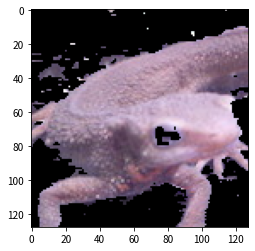

In [13]:
img = cv2.imread("imori.jpg")

hsv_img = functions.rgb2hsv(img)
mask = np.zeros_like(hsv_img[..., 0])
mask[np.logical_and((hsv_img[...,0]>=180),(hsv_img[...,0]<=260))] = 1
mask = 1- mask
mask = np.tile(mask,(3,1,1)).transpose(1,2,0)

out = img*mask
out = out.astype(np.uint8)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) 
plt.show()

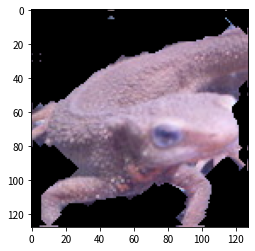

In [23]:
n=5
img = cv2.imread("imori.jpg")

hsv_img = functions.rgb2hsv(img)
mask = np.zeros_like(hsv_img[..., 0])
mask[np.logical_and((hsv_img[...,0]>=180),(hsv_img[...,0]<=260))] = 255

# クロージング処理
result = np.copy(mask)
for i in range(n):
    result = functions.morphology_expand(result)
    
for i in range(n):
    result = functions.morphology_shrinkage(result)
    
# オープニング処理
for i in range(n):
    result = functions.morphology_shrinkage(result)
    
for i in range(n):
    result = functions.morphology_expand(result)

result//=255
result = 1-result
mask = np.tile(result,(3,1,1)).transpose(1,2,0)
out = img*mask
out = out.astype(np.uint8)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) 
plt.show()

# 縮小と拡大

imori.jpgをグレースケールにしたものを0.5倍に縮小した後に2倍に拡大した画像を求めよ。 この処理を行うと、ぼやけた画像ができる。

拡大縮小にはbi-linear補間を用いよ。bi-linear補間をメソッド（関数）化すると、プログラムが簡潔にできる。

In [31]:
def bi_linear(img,ax=1,ay=1):
    h,w,l = img.shape
    h_a = int(ay*h)
    w_a = int(ax*w)
    # get position of resized image
    y = np.arange(h_a).repeat(w_a).reshape(h_a, -1)
    x = np.tile(np.arange(w_a), (h_a, 1))

    # get position of original position
    y = (y / ay)
    x = (x / ax)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)

    ix = np.minimum(ix, w-2)
    iy = np.minimum(iy, h-2)

    # get distance 
    dx = x - ix
    dy = y - iy

    dx = np.repeat(np.expand_dims(dx, axis=-1), 3, axis=-1)
    dy = np.repeat(np.expand_dims(dy, axis=-1), 3, axis=-1)
    
    # interpolation
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out

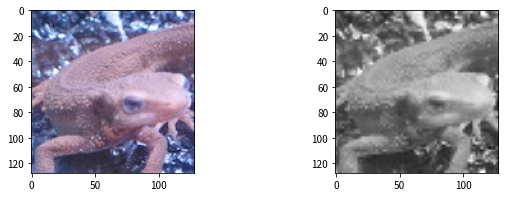

In [38]:
img = cv2.imread("imori.jpg")

result = bi_linear(img,0.5,0.5)
result = bi_linear(result,2.0,2.0)
out = functions.grayscale(result)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2RGB)) 
plt.show()

# Q74 ピラミッド差分による高周波成分の抽出

Q.73で求めた画像と元画像の差分を求め、[0,255]に正規化せよ。

ここで求めた画像はエッジとなっている。つまり、画像中の高周波成分をとったことになる。

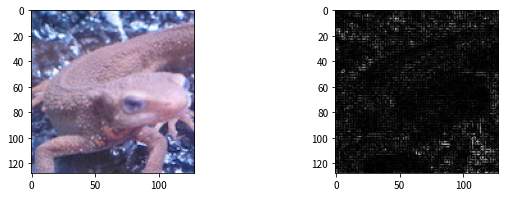

In [41]:
img = cv2.imread("imori.jpg")

gray_img = functions.grayscale(img)

result = bi_linear(img,0.5,0.5)
result = bi_linear(result,2.0,2.0)
out = functions.grayscale(result)

out = np.abs(out-gray_img)
out = out/out.max()*255

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2RGB)) 
plt.show()

# Q75 ガウシアンピラミッド

ここでは、元画像を1/2, 1/4, 1/8, 1/16, 1/32にリサイズした画像を求めよ。

このように元画像を小さくリサイズして重ねたものをガウシアンピラミッドと呼ぶ。

このガウシアンピラミッドの概念は現在でも有効であり、画像をきれいにする超解像を行うディープラーニングの手法でもガウシアンピラミッドの概念が用いられる。

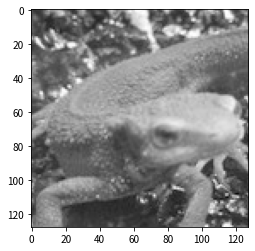

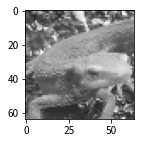

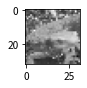

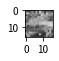

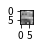

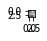

In [55]:
img = cv2.imread("imori.jpg")
gray_img = functions.grayscale(img)
pyramid = [gray_img]

for i in range(1,6):
    b = 1/(2**i)
    b_img = bi_linear(img,b,b)
    b_img = functions.grayscale(b_img)
    pyramid.append(b_img)


for i in range(1,7):
    #plt.subplot(1,6,i)
    H,W = pyramid[i-1].shape
    plt.figure(figsize=(W/32,H/32))
    plt.imshow(cv2.cvtColor(pyramid[i-1].astype(np.uint8), cv2.COLOR_BGR2RGB)) 
    plt.show()


# Q76 顕著性マップ

ここではガウシアンピラミッドを用いた簡単な顕著性マップを作成する。

顕著性マップとは画像の中で人間の目を引きやすい領域を表した画像である。

現在ではディープラーニングによる顕著性マップがよく用いられるが、本来は画像のRGB成分やHSV成分などのガウシアンピラミッドを作成し、それらの差分から求める手法がよく用いられた(例えばIttiらの手法などがある)。

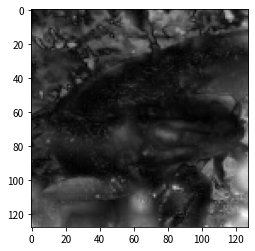

In [64]:
pairs = [[0,1],[0,3],[0,5],[1,4],[2,3],[3,5]]

bi_linear_pyramid = [gray_img]
for i in range(1,6):
    b = 1/(2**i)
    b_img = bi_linear(img,b,b)
    b = 2**i
    b_img = bi_linear(b_img,b,b)
    b_img = functions.grayscale(b_img)
    bi_linear_pyramid.append(b_img)
    
H, W = bi_linear_pyramid[0].shape
out = np.zeros((H, W), dtype=np.float32)
for pair in pairs:
    out += np.abs(bi_linear_pyramid[pair[0]]-bi_linear_pyramid[pair[1]])
    
out = out / out.max() * 255
#for i in range(1,7):
    #plt.subplot(1,6,i)
    #plt.figure()
    #plt.imshow(cv2.cvtColor(bi_linear_pyramid[i-1].astype(np.uint8), cv2.COLOR_BGR2RGB)) 
    #plt.show()
    
plt.imshow(cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2RGB)) 